NLP for Text Classfication to select only the ASD relevant subreddits - see discussion in *reddit_data.ipynb* : 

'From the above analysis we can see that the first 10 subreddits , by number of subscribers, do not seem to be related to ASD. 

=> Use NLP to filter out the ASD relavant subreddits : display_name + title + public_description + header_title + description (Text classification task - target categories: ASD vs Other. ) - Manually annotate 40% out of 534 subreddits -> train different models -> choose the best one to classify the rest 60% and get the final subreddits list.

As the private subreddits' data can't be accessed, these will be excluded from the analisys. The subreddits dataset will only inlcude those that are listed as 'public' or 'restricted' (= everyone can read the data but only certain people can post).

Features used: display_name + title + public_description + header_title + description

Pipeline for NLP:

1. get data (40% asd_final_rows_list.csv) and annotate it 
2. text extraction and cleanup - merge relevant information into one text column, remove punctuation/spelling mistakes etc. 
3. pre-processing:
    3.1 split text into tokens/words (=sentence segmentation/ tokanisation NLTK or Spcy or AutoTokenizer if using transformers)
    3.3 stemming (=remove prefixes and sufixes) and lemmatization (=get the base word - ext ate becomes (to)eat)
4. feature engineering (= convert text / document into vector)
    count-vector
    tf-idf
    one-hot encode - not really used due to size and sparcity problems
    word/token-emebeding
5. apply classifier ( any machine learning model classifier ) - use gridSearchCV to see which is the best performing classifier ?
6. evaluate  model: Accuracy, Precision, Recall, F1 score ( if not good , go back to preprocessing step )
7. Deploy
8. Monitor and update

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 Get data  - whole dataset

In [73]:
asd_subs_df = pd.read_csv('asd_final_rows_list.csv')
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             534 non-null    int64  
 1   restrict_posting       534 non-null    bool   
 2   display_name           534 non-null    object 
 3   title                  534 non-null    object 
 4   display_name_prefixed  534 non-null    object 
 5   subscribers            534 non-null    int64  
 6   name                   534 non-null    object 
 7   public_description     506 non-null    object 
 8   community_reviewed     534 non-null    bool   
 9   created                534 non-null    float64
 10  subreddit_type         534 non-null    object 
 11  id                     534 non-null    object 
 12  over18                 534 non-null    bool   
 13  header_title           81 non-null     object 
 14  description            393 non-null    object 
 15  url   

In [74]:
# select from the dataset only the text features neccesary for topic modeling + id 
# Features: display_name + title + public_description + header_title + description 
asd_subs_df = asd_subs_df[['id','display_name', 'title', 'public_description', 'header_title', 'description']]
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  534 non-null    object
 1   display_name        534 non-null    object
 2   title               534 non-null    object
 3   public_description  506 non-null    object
 4   header_title        81 non-null     object
 5   description         393 non-null    object
dtypes: object(6)
memory usage: 25.2+ KB


In [75]:
# public_description, header_title, description have missing data
# in the reddit_data.ipynb the missing data appears as an empty string, meaning the subreddit does not have any text added to these sections
# all NaN values will be replaced with an empty string 
# the text in each column will be agregated into one single text document as to include as much relevant words as possible for each subreddit
asd_subs_df.head(3)

,id,display_name,title,public_description,header_title,description
0,28lhh2,AutismRepresentation,Autism Awareness,A place for kind people who want to spread awa...,NaN,NaN
1,3b4rh,AspiePositive,"AspiePositive: by aspies, for aspies | no hate...","If you have Asperger's, you are welcome. If yo...",NaN,**The Golden Rule: Be excellent to each other....
2,2nwjjb,TrumpAutism,Trump Autism,Trump Autism,NaN,Trump Autism


In [76]:
# check missing data
asd_subs_df.isnull().sum()

id                      0
display_name            0
title                   0
public_description     28
header_title          453
description           141
dtype: int64

The dataset contains 534 entries, of which 28 are missing 'public_description' and 141 are missing 'description' and 453 are missing 'header_title'.

display_name and title have no missing data.

All text columns will be aggregated into one large text document ( to include all relevant words available for each subreddit).

## 1.2. Clean up and text extraction - whole data set

In [77]:
# replace NaN values with empty string ''
# NaN valuse are only observed for text columns: public_description, header_title, description
asd_subs_df = asd_subs_df.fillna('')
asd_subs_df.head(3)

,id,display_name,title,public_description,header_title,description
0,28lhh2,AutismRepresentation,Autism Awareness,A place for kind people who want to spread awa...,,
1,3b4rh,AspiePositive,"AspiePositive: by aspies, for aspies | no hate...","If you have Asperger's, you are welcome. If yo...",,**The Golden Rule: Be excellent to each other....
2,2nwjjb,TrumpAutism,Trump Autism,Trump Autism,,Trump Autism


In [78]:
# no more null values 
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  534 non-null    object
 1   display_name        534 non-null    object
 2   title               534 non-null    object
 3   public_description  534 non-null    object
 4   header_title        534 non-null    object
 5   description         534 non-null    object
dtypes: object(6)
memory usage: 25.2+ KB


In [79]:
# join text columns
asd_subs_df["text"] = asd_subs_df[["display_name", "title", 'public_description', 'header_title', 'description']].apply(" ".join, axis='columns')
asd_subs_df.head(3)

,id,display_name,title,public_description,header_title,description,text
0,28lhh2,AutismRepresentation,Autism Awareness,A place for kind people who want to spread awa...,,,AutismRepresentation Autism Awareness A place ...
1,3b4rh,AspiePositive,"AspiePositive: by aspies, for aspies | no hate...","If you have Asperger's, you are welcome. If yo...",,**The Golden Rule: Be excellent to each other....,"AspiePositive AspiePositive: by aspies, for as..."
2,2nwjjb,TrumpAutism,Trump Autism,Trump Autism,,Trump Autism,TrumpAutism Trump Autism Trump Autism Trump A...


In [80]:
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  534 non-null    object
 1   display_name        534 non-null    object
 2   title               534 non-null    object
 3   public_description  534 non-null    object
 4   header_title        534 non-null    object
 5   description         534 non-null    object
 6   text                534 non-null    object
dtypes: object(7)
memory usage: 29.3+ KB


In [81]:
# drop the individual text columns for easier visualisation
# only the text column will be used for the analysis
# keep id and display_name - to identify subreddits
asd_subs_df.drop(['title', 'public_description', 'header_title', 'description'], axis=1, inplace=True)
asd_subs_df.head(3)

,id,display_name,text
0,28lhh2,AutismRepresentation,AutismRepresentation Autism Awareness A place ...
1,3b4rh,AspiePositive,"AspiePositive AspiePositive: by aspies, for as..."
2,2nwjjb,TrumpAutism,TrumpAutism Trump Autism Trump Autism Trump A...


In [82]:
# invesitgate data further ( check text patterns that could be cleaned further )
asd_subs_df['text'].sample(n=20, random_state=7) 

327    autism__friends autism__friends a safe place f...
381    videos /r/videos Reddit's main subreddit for v...
482    mentalhealth Mental Health The Mental Health s...
55     offmychest Off My Chest | A Safe Community for...
273    AutismAndAddiction AutismAndAddiction A place ...
3      nevergrewup When the body got older but the mi...
97     IAmA IAmA I Am A, where the mundane becomes fa...
90     WritteND WritteND A space for Neurodivergent w...
204    asptrees asptrees the community for discussing...
70     Autisme_France Autisme_France Groupe qui conce...
478    Parenting Reddit Parenting - For those with ki...
395    genetics Genetics, genes, and genomes For disc...
472    Aspergians Aspergians A subreddit by and for s...
50     aspieselfies aspieselfies a place for people w...
306    AutisticPilking AutisticPilking Neco Arc is yo...
115    TheAspieWorld The Aspie World - Aspergers & Au...
109    CoronavirusUK CoronavirusUK Spreading news, ad...
132    AskMeAnythingIAnswer We 

Some terms appear in cammelCase - words capitalized and joined together - ex. *AutismAndAddiction*; Some terms are separated by _ : ex. *autism__friends*. We can separate these words by white spaces using regular expressions. However, some words are joined together with no clear delimitation (ex. *nevergrewup* ). In this situation we can't separate the words, but the deep leaning approach should be able to tokenize this text in a relevant way as these models split the text into single characters or groups of characters, or use bytes instead of characters/words ( see : Unigrams (Gasparetto et al., 2022)). To clean the data in this section cammelCase, dashes and underscores will be replaced by white spaces in the dataset. Concatenated strings of words with no clear delimitation will be left unchanged in the dataset. 

In [84]:
# function to find and replace all cammelCase, dash and undreline joined words
import re
def split_words_by_space(text):
    # split camelCase
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text) 
    # replace underscores and dashes with spaces
    text = re.sub(r'[_-]+', ' ', text)  

    return text

In [85]:
# split text words by spaces
asd_subs_df['text'] = asd_subs_df['text'].apply(split_words_by_space)

In [86]:
asd_subs_df['text'].sample(n=20, random_state=7) 

327    autism friends autism friends a safe place for...
381    videos /r/videos Reddit's main subreddit for v...
482    mentalhealth Mental Health The Mental Health s...
55     offmychest Off My Chest | A Safe Community for...
273    Autism And Addiction Autism And Addiction A pl...
3      nevergrewup When the body got older but the mi...
97     IAm A IAm A I Am A, where the mundane becomes ...
90     Writte ND Writte ND A space for Neurodivergent...
204    asptrees asptrees the community for discussing...
70     Autisme France Autisme France Groupe qui conce...
478    Parenting Reddit Parenting   For those with ki...
395    genetics Genetics, genes, and genomes For disc...
472    Aspergians Aspergians A subreddit by and for s...
50     aspieselfies aspieselfies a place for people w...
306    Autistic Pilking Autistic Pilking Neco Arc is ...
115    The Aspie World The Aspie World   Aspergers & ...
109    Coronavirus UK Coronavirus UK Spreading news, ...
132    Ask Me Anything IAnswer 

Notice above that some of the subreddis are not in english (227-CasaAutistic, 70-Autisme_France)

Use langdetect to identify the language of the subreddits
(https://pypi.org/project/langdetect/)

In [87]:
%%capture
%pip install langdetect

In [88]:
# detect langage of subreddits text and save it in a 'lang' column
from langdetect import detect
asd_subs_df['lang'] = asd_subs_df['text'].apply(detect)

In [89]:
# 18 rows are identified as not being english
len(asd_subs_df[asd_subs_df['lang'] != 'en'])


18

In [90]:
# inspect rows manually to confirm language
# set the maximum column width to display all content
# pd.set_option('display.max_colwidth', 1)
asd_subs_df[asd_subs_df['lang'] != 'en'][['text', 'lang']]


,text,lang
2,Trump Autism Trump Autism Trump Autism Trump ...,lv
16,Aspergers After Dark Aspergers After Dark Migr...,da
56,autismogang autismogang,tl
70,Autisme France Autisme France Groupe qui conce...,fr
89,Onions Cause Autism Onions Cause Autism Onions...,fr
91,Asperger En Espanol Asperger En Espanol,es
93,Vidar Autism Vidar Autism Autistic Vidar minec...,de
214,aspergerinterests Asperger Interests,no
227,Casa Autistic Casa Autistic la casa autistic e...,ca
263,Autistic Pride2 Autistic Pride2,ro


Inspecting the rows above, the following row are confirmed as not being in English: 
56, 70, 91, 227, 388, 430, 487, 512



In [91]:
# drop the non-english rows
# 526 subreddits left in the dataset
non_en_rows_indices = [56, 70, 91, 227, 388, 430, 487, 512]
asd_subs_df = asd_subs_df.drop(non_en_rows_indices)
asd_subs_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 526 entries, 0 to 533
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            526 non-null    object
 1   display_name  526 non-null    object
 2   text          526 non-null    object
 3   lang          526 non-null    object
dtypes: object(4)
memory usage: 20.5+ KB


In [92]:
asd_subs_df['text'].sample(n=20, random_state=7) 

205    autismmemes autism memes Meme for people with\...
488    ASDcareers The Careers of People with ASD Livi...
231    Gamingcirclejerk Gaming Circlejerk   Don Chead...
104    autisticpeople Autism Spectrum Disorder News, ...
263                   Autistic Pride2 Autistic Pride2   
492    Baby Bumps Baby Bumps A place for pregnant red...
236    hypersensitivity Hypersensitivity A place for ...
3      nevergrewup When the body got older but the mi...
323    Everything Science Everything Science /r/Every...
506    aplusguide A+ Guide A+ Guide is a place for po...
66     Neurodivergent LGBTQ Neurodivergent LGBTQ Neur...
293    The Owl House The Owl House A subreddit for th...
317    traaaaaaannnnnnnnnns If youre memes and im mem...
529    Savant Savant This subreddit is dedicated to t...
278    Debate Vaccines Debate Vaccines Debate and dis...
51     intj analytical, conceptual and objective For ...
216    gaspies A place for gay aspies For the aspies ...
219    Council Of Autism Counci

In [93]:
# remove \n, /r/, r/, \r  - these characters are not relevant
asd_subs_df['text'] = asd_subs_df['text'].str.replace('\n', ' ').str.replace('/r/', ' ').str.replace('r/', ' ').str.replace('\r ', ' ')
asd_subs_df['text'].sample(n=20, random_state=7) 


205    autismmemes autism memes Meme for people with ...
488    ASDcareers The Careers of People with ASD Livi...
231    Gamingcirclejerk Gaming Circlejerk   Don Chead...
104    autisticpeople Autism Spectrum Disorder News, ...
263                   Autistic Pride2 Autistic Pride2   
492    Baby Bumps Baby Bumps A place for pregnant red...
236    hypersensitivity Hypersensitivity A place for ...
3      nevergrewup When the body got older but the mi...
323    Everything Science Everything Science  Everyth...
506    aplusguide A+ Guide A+ Guide is a place for po...
66     Neurodivergent LGBTQ Neurodivergent LGBTQ Neur...
293    The Owl House The Owl House A subreddit for th...
317    traaaaaaannnnnnnnnns If youre memes and im mem...
529    Savant Savant This subreddit is dedicated to t...
278    Debate Vaccines Debate Vaccines Debate and dis...
51     intj analytical, conceptual and objective For ...
216    gaspies A place for gay aspies For the aspies ...
219    Council Of Autism Counci

In [94]:
# use regex to replace non-word characters with space - these chars are not relevant to the text analysis
def remove_non_word_chars(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    return cleaned_text

In [95]:
# replace non-word characters with space
asd_subs_df['text'] = asd_subs_df['text'].apply(remove_non_word_chars)
asd_subs_df['text'].sample(n=20, random_state=7) 

205    autismmemes autism memes Meme for people with ...
488    ASDcareers The Careers of People with ASD Livi...
231    Gamingcirclejerk Gaming Circlejerk   Don Chead...
104    autisticpeople Autism Spectrum Disorder News  ...
263                   Autistic Pride2 Autistic Pride2   
492    Baby Bumps Baby Bumps A place for pregnant red...
236    hypersensitivity Hypersensitivity A place for ...
3      nevergrewup When the body got older but the mi...
323    Everything Science Everything Science  Everyth...
506    aplusguide A  Guide A  Guide is a place for po...
66     Neurodivergent LGBTQ Neurodivergent LGBTQ Neur...
293    The Owl House The Owl House A subreddit for th...
317    traaaaaaannnnnnnnnns If youre memes and im mem...
529    Savant Savant This subreddit is dedicated to t...
278    Debate Vaccines Debate Vaccines Debate and dis...
51     intj analytical  conceptual and objective For ...
216    gaspies A place for gay aspies For the aspies ...
219    Council Of Autism Counci

In [96]:
asd_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 526 entries, 0 to 533
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            526 non-null    object
 1   display_name  526 non-null    object
 2   text          526 non-null    object
 3   lang          526 non-null    object
dtypes: object(4)
memory usage: 20.5+ KB


## 1.3. Get dataset for model selection -  anotated data
40% of 526 = 210.4 -> split train-test 80%-20%( use cross validation as the dataset is small)

In [97]:
asd_subs_annotated_df = asd_subs_df[['text']]
asd_subs_annotated_df.head(3)

,text
0,Autism Representation Autism Awareness A place...
1,Aspie Positive Aspie Positive by aspies for ...
2,Trump Autism Trump Autism Trump Autism Trump ...


In [98]:
# select at random 40% of rows in the dataset to be manually annotated into 2 categories: asd and other
# 40% out of 542 = 210 - > text clasiffication needs a large number of documents to train : at least 100 , ideally 1000 ( http://benschmidt.org/medhist16/index.html%3Fp=16.html#:~:text=Topic%20modeling%20can%20work%20on,short%20as%20a%20paragraph%20apiece.)\
# it can be done with this dataset but it very close to the minumm limit ( limitation )
np.random.seed(7)
asd_subs_annotated_df = asd_subs_annotated_df.sample(frac=0.4)
asd_subs_annotated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 205 to 282
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    210 non-null    object
dtypes: object(1)
memory usage: 3.3+ KB


In [99]:
# save the data in a csv file to be annotated
asd_subs_annotated_df.to_csv('annotated_data/asd_subs_to_annotate.csv')

In [100]:
# load annotated dataset
data_path = 'annotated_data/asd_subs_annotated.csv'
asd_subs_annotated_df = pd.read_csv(data_path)
asd_subs_annotated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  210 non-null    int64 
 1   text        210 non-null    object
 2   Category    210 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.0+ KB


In [101]:
asd_subs_annotated_df.head(3)

,Unnamed: 0,text,Category
0,205,autismmemes autism memes Meme for people with ...,asd
1,488,ASDcareers The Careers of People with ASD Livi...,asd
2,231,Gamingcirclejerk Gaming Circlejerk Don Chead...,other


In [102]:
# Unnamed: 0 is the index in the original dataset
# this column was changed by apple's Numbers program when the file was annotated
# set it as the index ( to keep the original indexes of the subreddits )
asd_subs_annotated_df.set_index('Unnamed: 0', inplace=True)
asd_subs_annotated_df.head(3)

,text,Category
Unnamed: 0,,
205,autismmemes autism memes Meme for people with ...,asd
488,ASDcareers The Careers of People with ASD Livi...,asd
231,Gamingcirclejerk Gaming Circlejerk Don Chead...,other


In [103]:
# remove the index column name
asd_subs_annotated_df.index.names = [None]
# category contains 2 classes : asd (=autism related) and other (= not autism ralated)
# the annotations were made by the author alone
asd_subs_annotated_df.head(3)

,text,Category
205,autismmemes autism memes Meme for people with ...,asd
488,ASDcareers The Careers of People with ASD Livi...,asd
231,Gamingcirclejerk Gaming Circlejerk Don Chead...,other


In [104]:
# category contains 2 classes : asd (=autism related) and other (= not autism ralated)
# the annotations were made by the author alone
asd_subs_annotated_df.head(3)

,text,Category
205,autismmemes autism memes Meme for people with ...,asd
488,ASDcareers The Careers of People with ASD Livi...,asd
231,Gamingcirclejerk Gaming Circlejerk Don Chead...,other


In [105]:
# descriptive statistics
asd_subs_annotated_df.groupby('Category').describe()

text                                                               
         count unique                                                top freq
Category                                                                     
Asd          6      6  gaspies A place for gay aspies For the aspies ...    1
Other        4      4  Baby Bumps Baby Bumps A place for pregnant red...    1
asd        107    107  autismmemes autism memes Meme for people with ...    1
ohter        1      1  Ask Me Anything IAnswer We will try to answer ...    1
other       92     92  Gamingcirclejerk Gaming Circlejerk   Don Chead...    1

In [106]:
# lower case all entries in category column
asd_subs_annotated_df['Category'] = asd_subs_annotated_df['Category'].str.lower()
asd_subs_annotated_df.groupby('Category').describe()

text                                                               
         count unique                                                top freq
Category                                                                     
asd        113    113  autismmemes autism memes Meme for people with ...    1
ohter        1      1  Ask Me Anything IAnswer We will try to answer ...    1
other       96     96  Gamingcirclejerk Gaming Circlejerk   Don Chead...    1

In [107]:
# one entry is miss spelled 
# replace 'ohter' for 'other' in Category
asd_subs_annotated_df['Category'] = asd_subs_annotated_df['Category'].replace('ohter', 'other')
asd_subs_annotated_df.groupby('Category').describe()

text                                                               
         count unique                                                top freq
Category                                                                     
asd        113    113  autismmemes autism memes Meme for people with ...    1
other       97     97  Gamingcirclejerk Gaming Circlejerk   Don Chead...    1

The dataset is relatively ballanced, with 113 subreddits in the ASD category and 97 in the other (non-ASD) category. 

In balanced datasets accuracy can be a reasonable measure for assessing the performance of a model. However , other metrics will be used in addition to accuracy, to evaluate the performance of the model: precission, recall and F1-score.

In [108]:
# save the length of text in a new column 'text_tength' 
asd_subs_annotated_df['text_length'] = asd_subs_annotated_df['text'].apply(lambda x: len(x))
asd_subs_annotated_df.head(3)

,text,Category,text_length
205,autismmemes autism memes Meme for people with ...,asd,72
488,ASDcareers The Careers of People with ASD Livi...,asd,1140
231,Gamingcirclejerk Gaming Circlejerk Don Chead...,other,2279


In [109]:
# text length statisitic for the whole dataset
print(asd_subs_annotated_df['text_length'].describe())

count      210.000000
mean      1892.104762
std       2271.259118
min         22.000000
25%        204.500000
50%        663.500000
75%       3184.000000
max      10227.000000
Name: text_length, dtype: float64


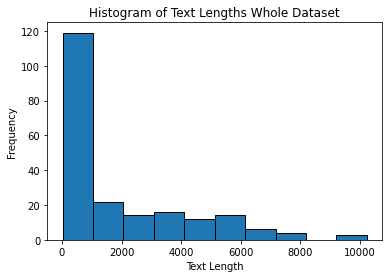

In [110]:
# plot a histogram for 'text_length' values
plt.hist(asd_subs_annotated_df['text_length'], bins=10, edgecolor='k')

# labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths Whole Dataset')

plt.show()

In [111]:
# show text length for each of the 2 categories
# filter rows where 'Category' = 'other'
other_df = asd_subs_annotated_df[asd_subs_annotated_df['Category'] == 'other']
# filter rows where 'Category' = 'asd'
asd_df = asd_subs_annotated_df[asd_subs_annotated_df['Category'] == 'asd']

# text lenght statistics for 'Category' = 'other'
print('text lenght statistics for Category=other')
print(other_df['text_length'].describe())
# text lenght statistics for 'Category' = 'asd'
print()
print('text lenght statistics for Category=asd')
print(asd_df['text_length'].describe())


text lenght statistics for Category=other
count       97.000000
mean      3345.484536
std       2478.789818
min         22.000000
25%       1078.000000
50%       3005.000000
75%       5186.000000
max      10227.000000
Name: text_length, dtype: float64

text lenght statistics for Category=asd
count     113.000000
mean      644.513274
std       979.758390
min        28.000000
25%       122.000000
50%       324.000000
75%       623.000000
max      4892.000000
Name: text_length, dtype: float64


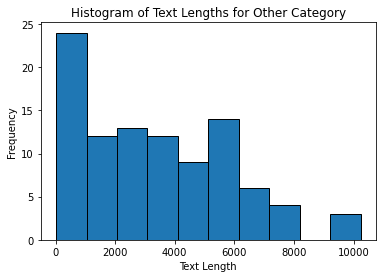

In [112]:
# plot a histogram for 'text_length' values of other category
plt.hist(other_df['text_length'], bins=10, edgecolor='k')

# labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths for Other Category')

plt.show()

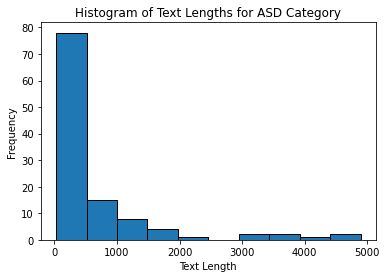

In [113]:
# plot a histogram for 'text_length' values of asd category
plt.hist(asd_df['text_length'], bins=10, edgecolor='k')

# labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths for ASD Category')

plt.show()

The average text length for the whole data set is 1892 characters. Text descriptions vary between a minumum of 22 characters to a maximum of 10227 characters. 

The mean (1892) is almost triple the median value (663). This indicates that the distribution is positively skewed - the tail on the right side (higher values) is longer compared to the left side (lower values), as seen in the histogram above. This indicates that there are some very high values (outliers) pulling the mean upward. 

https://www.analyticsvidhya.com/blog/2020/07/what-is-skewness-statistics/:
Since our data is positively skewed here, it means that it has a higher number of data points having low values (shorter text descriptions). So when we train our model on this data, it will perform better at predicting the category of subreddtis with shorter descriptions as compared to those with longer horsepower. (?)

This statistics represent text_lenght in terms of characters (inlcuding white-space). Skewed data is typical in NLP tasks. The text will need to be transformed (tokenisation) and projected into a feature space. 
All lenght text will be included in the analysis, in order to develop the largest vocabulary possible. 
As most text descriptions are under 1000 characters, i will expect models to perform best on short text.
Also, the 'other' category text data seems to be more balancend, while the 'asd' category seems to containt mostly short text (under 500 chars). Thus i would expect the models to perform better at classifing the other category ( True  negavies). (?)

In [114]:
# Category is a categorical variable
# needs to be turned into a numerical type for the analysis
# create a new column 'Asd' for the numerical values of Category: 0 = Other, 1 = Asd
asd_subs_annotated_df['asd']= asd_subs_annotated_df['Category'].apply(lambda x: 1 if x=='asd' else 0)
asd_subs_annotated_df.head(3)

,text,Category,text_length,asd
205,autismmemes autism memes Meme for people with ...,asd,72,1
488,ASDcareers The Careers of People with ASD Livi...,asd,1140,1
231,Gamingcirclejerk Gaming Circlejerk Don Chead...,other,2279,0


In [115]:
asd_subs_annotated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 205 to 282
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         210 non-null    object
 1   Category     210 non-null    object
 2   text_length  210 non-null    int64 
 3   asd          210 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 8.2+ KB


In [221]:
# we will only use in the following analysis columns text and asd
asd_subs_annotated_df_short = asd_subs_annotated_df[['asd', 'text']]
asd_subs_annotated_df_short.head(3)

,asd,text
205,1,autismmemes autism memes Meme for people with ...
488,1,ASDcareers The Careers of People with ASD Livi...
231,0,Gamingcirclejerk Gaming Circlejerk Don Chead...


In [222]:
# split the data into train set ( 0.8 of the dataset ) and test set of (0.2 of the dataset)
from sklearn.model_selection import train_test_split
X = asd_subs_annotated_df_short[['text']]
y = asd_subs_annotated_df_short[['asd']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)


In [223]:
print('Training Dataset')
X_train.info()
print()
y_train.info()
print()
print('Asd-Other distribution')
print(y_train.value_counts())

Training Dataset
<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 116 to 441
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    168 non-null    object
dtypes: object(1)
memory usage: 2.6+ KB

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 116 to 441
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   asd     168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB

Asd-Other distribution
asd
1      90
0      78
Name: count, dtype: int64


Training data contains 168 non-null values, and is relatively ballanced (90 subreddits are in the asd category and 78 are in the other category).

In [224]:
print('Test Dataset')
X_test.info()
print()
y_test.info()
print()
print('Asd-Other distribution')
print(y_test.value_counts())


Test Dataset
<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 231 to 426
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42 non-null     object
dtypes: object(1)
memory usage: 672.0+ bytes

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 231 to 426
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   asd     42 non-null     int64
dtypes: int64(1)
memory usage: 672.0 bytes

Asd-Other distribution
asd
1      23
0      19
Name: count, dtype: int64


Training data contains 42 non-null values, and is relatively ballanced (23 subreddits are in the asd category and 19 are in the other category).

Both training and testing datasets are cleaned and ready for analysis.
Cross validation will be used , instead of a stand alone validation set, due to the small training set size.

I will apply different models used for supervised text classification. The best perfomant model will be used further to select the relevant asd(=autism) subreddits from the entire original dataset. 

List of models used:
- text classification with Naive Bayes 
- text classification with KNeighborsClassifier
- text classification with Random Forest
- text classification with SVM (lienar = assumes the shape of the decision boundary is linear;  and RBF = for when you don't have prior knowledge about the shape of the decision boundary)

## 3. Pre-processing:
Text data is unstructured data. Preprocessing this data is a first step to give this data some form of structure. 

    3.1 split text into tokens/words (=sentence segmentation/ tokanisation NLTK or Spcy or AutoTokenizer if using transformers)

    3.3 stemming (=remove prefixes and sufixes) and lemmatization (=get the base word - ext ate becomes (to)eat) - in this project lemmatization will be used as it can more accurately find the base word ( it has more complex rules than stemming -  see https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/#:~:text=Stemming%20is%20a%20process%20that,form%2C%20which%20is%20called%20Lemma.) 

#### Tokenize with spaCy

In [225]:
%%capture
%pip install -U spacy

In [226]:
import spacy

In [227]:
%%capture
!python -m spacy download en_core_web_lg

In [228]:
nlp = spacy.load('en_core_web_lg')

In [229]:
X_train.head(3)

,text
116,womenonthespectrum womenonthespectrum A commun...
293,The Owl House The Owl House A subreddit for th...
452,Autism Speaks Sucks Autism Speaks Sucks A comm...


In [230]:
# remove any stop words ( that were potentially missed by regex above) - > not relevant to the classification task
# remove punctuation - not relevant to classification (?maybe)
# lemmatize tokens
def preprocess(text):
    doc= nlp(text)
    new_text = []
    for t in doc:
        if t.is_stop or t.is_punct:
            continue
        new_text.append(t.lemma_)
    return ' '.join(new_text)

In [231]:
# pre-process traning set 
X_train.loc[:, 'new_text'] = X_train['text'].apply(preprocess)
X_train.head(3)

,text,new_text
116,womenonthespectrum womenonthespectrum A commun...,womenonthespectrum womenonthespectrum communit...
293,The Owl House The Owl House A subreddit for th...,Owl House Owl House subreddit Disney fantasy c...
452,Autism Speaks Sucks Autism Speaks Sucks A comm...,autism speak Sucks autism speak suck community...


In [232]:
# difference in text before and after preprocessing
doc_text = nlp(X_train.text[116])
doc_new_text = nlp(X_train.new_text[116])
print([t.text for t in doc_text])
print([t.text for t in doc_new_text])

['womenonthespectrum', 'womenonthespectrum', 'A', 'community', 'specifically', 'for', 'women', ' ', 'nonbinary', ' ', 'and', 'afab', 'people', 'on', 'the', 'spectrum', 'to', 'vent', ' ', 'discuss', 'topics', 'related', 'to', 'autism', ' ', 'and', 'support', 'each', 'other', '  ']
['womenonthespectrum', 'womenonthespectrum', 'community', 'specifically', 'woman', '  ', 'nonbinary', '  ', 'afab', 'people', 'spectrum', 'vent', '  ', 'discuss', 'topic', 'relate', 'autism', '  ', 'support', '  ']


In [233]:
# pre-process testinf set 
X_test.loc[:, 'new_text'] = X_test['text'].apply(preprocess)
X_test.head(3)

,text,new_text
231,Gamingcirclejerk Gaming Circlejerk Don Chead...,Gamingcirclejerk Gaming Circlejerk Don Chea...
243,ASDpeersupport ASD Peer Support Peer based s...,ASDpeersupport ASD Peer support Peer base s...
392,selfharm A Subreddit for Self Harmers A subred...,selfharm Subreddit Self Harmers subreddit self...


## 4. 5. 6. Vectorize, Apply Classifier and Evaluate the model - uses sklearn.pipeline


4. feature engineering (= convert text / document into vector)
    count-vector
    tf-idf
    one-hot encode - not really used due to size and sparcity problems
    word/token-emebeding
5. apply classifier ( any machine learning model classifier ) - use gridSearchCV to see which is the best performing classifier ?
6. evaluate  model: Accuracy, Precision, Recall, F1 score ( if not good , go back to preprocessing step )

In [270]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold, cross_val_predict

from sklearn.metrics import classification_report, confusion_matrix

def classify(vectorizer, model, x_train, y_train, x_test, y_test, k_folds=5):
    # create the pipeline
    clf = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])
    # initialize StratifiedKFold for cross-validation
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # perform k-fold (k=5) cross-validation 
    y_pred_cv = cross_val_predict(clf, x_train, y_train, cv=kf)
    
    # fit the model on the training data
    clf.fit(x_train, y_train)
    # make prediction using test data
    y_pred = clf.predict(x_test)

    # classification report and confusion matrix for cross-validated predictions
    print("Cross-validated Classification Report:\n", classification_report(y_train, y_pred_cv))
    print("Cross-validated Confusion Matrix:\n", confusion_matrix(y_train, y_pred_cv))
    
    # classification report and confusion matrix for test data 
    print("\nTest Data Classification Report:\n", classification_report(y_test, y_pred))
    print("Test Data Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [268]:
y_train.asd.shape, X_train.new_text.shape


((168,), (168,))

In [269]:
np.random.seed(7)
vectorizers = [CountVectorizer(), TfidfVectorizer()]
models = [KNeighborsClassifier(), MultinomialNB(), RandomForestClassifier(), SVC(kernel='linear'), SVC(kernel='rbf')]

for v in vectorizers:
    print(v)
    for m in models:
        print(v, m)
        classify(v, m, X_train.new_text, y_train.asd, X_test.new_text, y_test.asd)
    print()
        

CountVectorizer()
CountVectorizer() KNeighborsClassifier()
Cross-validated Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.53      0.68        78
           1       0.70      0.98      0.82        90

    accuracy                           0.77       168
   macro avg       0.83      0.75      0.75       168
weighted avg       0.82      0.77      0.75       168

Cross-validated Confusion Matrix:
 [[41 37]
 [ 2 88]]

Test Data Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.53      0.69        19
           1       0.72      1.00      0.84        23

    accuracy                           0.79        42
   macro avg       0.86      0.76      0.76        42
weighted avg       0.85      0.79      0.77        42

Test Data Confusion Matrix:
 [[10  9]
 [ 0 23]]
CountVectorizer() MultinomialNB()
Cross-validated Classification Report:
               precision    recall  f

Using a simple frequency word count vectorisation method (CountVectorizer) resulted in an accuracy ranging from 0.79 for the Random Forest and KNN models, to a maximum of 0.88 for the Multinomial Naive Bayse model. The predictions were improved, as expected, when using TF-IDF to vectorize the tokens ( this way frequent words, common to all the documents are given lower importance, and less common words are given more weight): the accuracy of the predictions ranges from 0.79 for the Random Forest model to  0.93 for the SVM with a linear kernel ( the rbf kernel gives a similar accuracy - 0.90 ... ) - how to tell which less likely to ovefit????

In [ ]:

# to do : use fast text or word2vec + the classification models
# to do : text classificatoin with RoBERTa - pytorch and transformers